In [1]:
import pandas as pd 
import numpy as np
import pymc as pm
import pytensor as pt
import arviz as az

pd.options.mode.use_inf_as_na = True

### Prepare the data

In [2]:
# It's common for order history to go back further than marketing history
# Let's see how many days we need to eliminate
temp = pd.read_csv('regression_data.csv', index_col='DATE_KEY').fillna(0).sort_index()
temp['total_spend'] = temp.sum(axis=1) - temp.new_customers
temp['cumulative_spend'] = temp.total_spend.cumsum()

days_without_ad_spend = (temp.cumulative_spend == 0).sum()

In [3]:
# function to get data and slice it up for regression
def prepare_data(source, w, shift_w, adstock_L):
    
    # for any given window, we want to grab prior 10 days so that we can calculate ad stock for first date
    adstock_L = adstock_L

    # number of windows available
    windows = 1 + int((len(source) - adstock_L - 0.8*w)/shift_w) # len(oldest window) >= 0.8*w

    # prep windows for regressions
    inputs = {}
    for i in range(windows-1, -1, -1):
        shift = shift_w * i
        if shift == 0: combo = source.iloc[-w:,:].copy()
        else: combo = source.iloc[-w-shift:-shift,:].copy()
        #if shift == 0: combo = source.iloc[-adstock_L-w:,:].copy()
        #else: combo = source.iloc[-adstock_L-w-shift:-shift,:].copy()
        
        # saw down raw data
        inputs[combo.index.values.max()] = {}
        inputs[combo.index.values.max()]['combo_raw'] = combo.copy()
        
        # drop columns where less than half the days have values
        for col in combo.columns:
            if ((combo[col] != 0) & (~combo[col].isnull())).sum() < int(0.5*w):
                combo.drop(col, axis=1, inplace=True)
        inputs[combo.index.values.max()]['combo'] = combo
    return inputs

# import file
temp = pd.read_csv('regression_data.csv', index_col='DATE_KEY').fillna(0).sort_index()
temp = temp[[x for x in temp.columns if x not in ['Meta-1', 'Meta-2', 'Meta-3']]].iloc[days_without_ad_spend:,:].copy()

# save list of predictors
predictors = list(temp.columns)

# generate files for regression
inputs = prepare_data(temp, w=182, shift_w=182, adstock_L=10)
print(f'{len(inputs)} windows generated')

6 windows generated


In [4]:
keys, means, counts = [], [], []
for dt in inputs:
    temp = inputs[dt]['combo_raw'].copy()
    keys.append(dt)
    means.append(temp.mean(axis=0))
    counts.append((temp != 0).sum(axis=0))
temp = pd.concat([pd.concat(means, axis=1, keys=keys), \
                  pd.concat(counts, axis=1, keys=keys)], axis=0, keys=['means', 'counts'])
temp

2020-12-22   2021-06-22   2021-12-21   2022-06-21  \
means  Meta           6471.073883  2511.131344  7840.714616  6869.135286   
       Display ads    1282.624419   198.720582   721.400765   513.870309   
       Google         1685.604077  1482.043512  2217.894249  3018.419257   
       Perf max          0.000000     0.000000     0.000000     0.011538   
       Shopping       2773.366149  1360.026510  2688.334788  4736.552684   
       Video ads        92.297227    44.680495   441.832803  2181.384482   
       new_customers    21.912088    17.609890    24.027473    21.846154   
counts Meta            182.000000   182.000000   174.000000   182.000000   
       Display ads     182.000000   147.000000   182.000000   178.000000   
       Google          182.000000   182.000000   182.000000   182.000000   
       Perf max          0.000000     0.000000     0.000000     1.000000   
       Shopping        182.000000   182.000000   182.000000   182.000000   
       Video ads       128.000000   104.000000   176.000000   173.000000   
       new_customers   182.000000   182.000000   182.000000   182.000000   

                       2022-12-20   2023-06-20  
means  Meta           6359.150406  8704.350152  
       Display ads     433.895991   742.323896  
       Google         3321.876152  1198.529834  
       Perf max       3332.724206   391.422473  
       Shopping       1134.484325   485.707857  
       Video ads       386.953304     0.000000  
       new_customers    28.890110    20.208791  
counts Meta            182.000000   175.000000  
       Display ads     175.000000   182.000000  
       Google          182.000000   182.000000  
       Perf max        182.000000   182.000000  
       Shopping        139.000000   182.000000  
       Video ads        93.000000     0.000000  
       new_customers   182.000000   182.000000

### Run regressions

In [5]:
# normalise and get normalisation metrics so we can reverse them
def get_scalers(inputs):
    outputs = {}
    for x in inputs:
        combo = inputs[x]['combo'].copy()
        scalers = {}
        # initially normalised using mean and sigma, but negative spend values throw off PyMC
        for col in combo.columns:
            scalers[col] = {}
            scalers[col]['mean'] = 0 #combo[col].min()
            scalers[col]['std'] = combo[col].mean() - combo[col].min()
            combo[col] = (combo[col] - scalers[col]['mean']) / scalers[col]['std']
        outputs[x] = {}
        outputs[x]['scalers'] = scalers
        outputs[x]['scaled'] = combo
    return outputs

In [6]:
# saturation function used in https://youtu.be/UznM_-_760Y?t=471
def logistic_saturation(x, mu: float = 0.5):
    # x : Input tensor.
    # mu : Saturation parameter.
    return (1 - np.exp(-x * mu)) / (1 + np.exp(-x * mu))

# ad stock function used in https://youtu.be/UznM_-_760Y?t=471
def geometric_adstock_tt(x_t, alpha=0, L=84, normalize=True):
    w = pt.tensor.as_tensor_variable([pt.tensor.power(alpha, i) for i in range(L)])
    xx = pt.tensor.stack([pt.tensor.concatenate([pt.tensor.zeros(i), x_t[:x_t.shape[0] - i]]) for i in range(L)])
    if not normalize:
        y = pt.tensor.dot(w, xx)
    else:
        y = pt.tensor.dot(w / pt.tensor.sum(w), xx)
    return y

# See https://www.pymc-labs.io/blog-posts/reducing-customer-acquisition-costs-how-we-helped-optimizing-hellofreshs-marketing-budget/
# https://github.com/pymc-labs/pymc-marketing/blob/main/pymc_marketing/mmm/transformers.py
def tanh_saturation(x, b: float = 0.5, c: float = 0.5):
    # x : Input tensor.
    # b : Number of users at saturation. Must be non-negative.
    # c : Initial cost per user. Must be non-zero.
    return b * np.tanh(x / (b * c))

# https://towardsdatascience.com/modeling-marketing-mix-using-pymc3-ba18dd9e6e68
def hill_saturation(x, alpha, gamma): 
    return x ** alpha / (x ** alpha + gamma ** alpha)

In [7]:
slope_distribution = ['exponential', 'gamma'][1] # Gamma tends to behave better

outputs = get_scalers(inputs)
for dt in outputs:#[max(outputs)]:#outputs:#[max(outputs)]:
    combo = outputs[dt]['scaled'].fillna(0)
    nc_mean = combo['new_customers'].mean()
    nc_std = combo['new_customers'].std()
    intercept_alpha = (nc_mean**2)/(nc_std**2)
    intercept_beta = nc_std/nc_mean
    
    outputs[dt]['models'] = {}
    for adstock in ['no adstock', 'adstock - meta', 'adstock - all', 'adstock only']: #['adstock only']

        # number of channels we want to add an ad stock variable to
        if adstock == 'no adstock': adstock_channels = []
        elif adstock == 'adstock - meta': adstock_channels = ['Meta']
        elif adstock == 'adstock - all': adstock_channels = [x for x in list(combo.columns) if x != 'new_customers']
        elif adstock == 'adstock only': adstock_channels = [x for x in list(combo.columns) if x != 'new_customers']

        # model name for downstream analysis
        model_name = slope_distribution + ', ' + adstock
        outputs[dt]['models'][model_name] = {}

        # build the model
        with pm.Model() as model:
            #noise = pm.Exponential('noise', lam=1)
            noise = pm.HalfNormal('noise', sigma=10)
            mu = pm.Gamma('Intercept', alpha=intercept_alpha, beta=intercept_beta)
            for param in combo.columns[:-1].to_list():
                if adstock != 'adstock only':
                    adstock_shift = 1
                    if slope_distribution == 'exponential': slope = pm.Exponential(f'{param}', lam=1)
                    elif slope_distribution == 'gamma': slope = pm.Gamma(f'{param}', alpha=3, beta=1) 
                    mu += np.asarray(combo[param]) * slope
                else: adstock_shift = 0
                if param in adstock_channels:
                    if slope_distribution == 'exponential': slope_adstock = pm.Exponential(f'{param}_adstock', lam=1)
                    elif slope_distribution == 'gamma': slope_adstock = pm.Gamma(f'{param}_adstock', alpha=3, beta=1)
                    #alpha = pm.Beta(f'{param}_alpha', alpha=1, beta=3)
                    mu += geometric_adstock_tt(np.asarray(combo[param].shift(adstock_shift).fillna(0)), alpha=0.7, L=10) * slope_adstock
            Y_obs = pm.Normal('Y_obs', \
                              mu=mu, \
                              sigma=noise, \
                              observed=np.asarray(combo['new_customers']))

            # save findings for downstream analysis
            outputs[dt]['models'][model_name]['idata'] = pm.sample(2000, cores=8, return_inferencedata=True)
            # other stats to consider saving: trace.stat_names

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [noise, Intercept, Meta, Display ads, Google, Shopping, Video ads]


Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 28 seconds.
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [noise, Intercept, Meta, Meta_adstock, Display ads, Google, Shopping, Video ads]


Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 28 seconds.
There were 13 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [noise, Intercept, Meta, Meta_adstock, Display ads, Display ads_adstock, Google, Google_adstock, Shopping, Shopping_adstock, Video ads, Video ads_adstock]


Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 36 seconds.
There were 18 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [noise, Intercept, Meta_adstock, Display ads_adstock, Google_adstock, Shopping_adstock, Video ads_adstock]


Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 26 seconds.
There were 30 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [noise, Intercept, Meta, Display ads, Google, Shopping, Video ads]


Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 27 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [noise, Intercept, Meta, Meta_adstock, Display ads, Google, Shopping, Video ads]


Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 28 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [noise, Intercept, Meta, Meta_adstock, Display ads, Display ads_adstock, Google, Google_adstock, Shopping, Shopping_adstock, Video ads, Video ads_adstock]


Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 46 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [noise, Intercept, Meta_adstock, Display ads_adstock, Google_adstock, Shopping_adstock, Video ads_adstock]


Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 29 seconds.
There were 9 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [noise, Intercept, Meta, Display ads, Google, Shopping, Video ads]


Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 29 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [noise, Intercept, Meta, Meta_adstock, Display ads, Google, Shopping, Video ads]


Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 32 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [noise, Intercept, Meta, Meta_adstock, Display ads, Display ads_adstock, Google, Google_adstock, Shopping, Shopping_adstock, Video ads, Video ads_adstock]


Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 46 seconds.
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [noise, Intercept, Meta_adstock, Display ads_adstock, Google_adstock, Shopping_adstock, Video ads_adstock]


Sampling 8 chains for 1_000 tune and 2_000 draw iterations (8_000 + 16_000 draws total) took 62 seconds.
There were 6 divergences after tuning. Increase `target_accept` or reparameterize.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (8 chains in 8 jobs)
NUTS: [noise, Intercept, Meta, Display ads, Google, Shopping, Video ads]


### Process traces from PyMC

In [ ]:
# rescales regression outputs for end-user consumption
def rescale(coefs, scalers, y):
    b = {}
    b['Intercept'] = coefs['Intercept'] * scalers[y]['std'] + scalers[y]['mean']
    for x, coef in coefs.items():
        if x not in ['Intercept', 'noise']:
            if x in scalers:
                b[x] = coef * scalers[y]['std'] / scalers[x]['std']
                b['Intercept'] = b['Intercept'] - b[x] * scalers[x]['mean']
                b[x] = b[x] ** -1
            if x[:-8] in scalers:
                b[x] = coef * scalers[y]['std'] / scalers[x[:-8]]['std']
                b['Intercept'] = b['Intercept'] - b[x] * scalers[x[:-8]]['mean']
                b[x] = b[x] ** -1
        elif x == 'noise': b[x] = coef
    return b

def process_idata(idata, scalers):
    coefs = {}
    trace_summary = az.summary(idata).filter(['mean','sd','hdi_3%','hdi_97%'])
    metrics = trace_summary.loc[['Intercept', 'noise'], :]
    metrics = pd.concat([
            metrics,
            pd.DataFrame({'mean': [idata.sample_stats.diverging.data.sum()]}, index=['Divergences'])
        ],
        axis=0
    )
    trace_summary = trace_summary.loc[[x for x in trace_summary.index if x != 'noise'], :]
    coefs = rescale(trace_summary['mean'].to_dict(), scalers, 'new_customers')

    coefs = pd.DataFrame.from_dict(coefs, orient='index').rename({0: 'coef'}, axis=1)
    coefs['channel'] = coefs.index.map(lambda x: x[:-8] if '_adstock' in x else x)
    coefs['source'] = coefs.index.map(lambda x: 'stock' if '_adstock' in x else 'base')
    coefs = pd.pivot_table(coefs, index='channel', columns='source', values='coef', aggfunc='sum')
    if coefs['base'].count() == 1:
        coefs['combined'] = coefs.stock.copy()
    elif 'stock' in coefs.columns:
        coefs['combined'] = (coefs.base ** -1 + coefs.stock.fillna(0).apply(lambda x: x ** -1 if x!= 0 else 0)) ** -1
        coefs['percent_conversion'] = (coefs.base ** -1) / (coefs.base ** -1 + coefs.stock ** -1)
    else: coefs['combined'] = coefs.base.copy()
    return [metrics, coefs]

metrics, coefs = {}, {}
for dt in outputs:
    metrics[dt] = {}
    coefs[dt] = {}
    for model_name in outputs[dt]['models']:
        temp = process_idata(outputs[dt]['models'][model_name]['idata'], outputs[dt]['scalers'])
        metrics[dt][model_name] = temp[0]
        coefs[dt][model_name] = temp[1]

In [ ]:
summaries, models = [], []
for model in metrics[max(metrics)]:
    slices, keys = [], []
    for dt in metrics:
        slices.append(metrics[dt][model]['mean'])
        keys.append(dt)
    summaries.append(pd.concat(slices, axis=1, keys=keys))
    models.append(model)
checks = pd.concat(summaries, axis=0, keys=models).reset_index().rename({'level_0': 'model', 'level_1': 'param'}, axis=1)
checks = checks.sort_values(by=['param', 'model']).set_index(['param', 'model'])
checks

,,2020-12-22,2021-06-22,2021-12-21,2022-06-21,2022-12-20,2023-06-20
param,model,,,,,,
Divergences,"gamma, adstock only",145.000,0.000,5.000,5.000,5.000,0.000
Intercept,"gamma, adstock only",0.034,0.123,0.351,0.279,0.331,0.393
noise,"gamma, adstock only",1.429,0.660,0.878,0.591,0.843,0.326


In [ ]:
def process_rolling_windows(x, field):
    summaries, models = [], []
    for model in metrics[max(x)]:
        slices, keys = [], []
        for dt in metrics:
            if field in x[dt][model]:
                slices.append(x[dt][model][field])
            else:
                temp = x[dt][model].iloc[:,0]
                temp.rename({temp.name: field}, inplace=True)
                temp = temp + np.nan
                slices.append(temp)
            keys.append(dt)
        summaries.append(pd.concat(slices, axis=1, keys=keys))
        models.append(model)
    summary = pd.concat(summaries, axis=0, keys=models).reset_index().rename({'level_0': 'model', \
                                                                              'level_1': 'param', \
                                                                              'channel': 'param'}, axis=1)
    summary = summary.sort_values(by=['param', 'model']).set_index(['param', 'model'])
    return summary

summaries, params = [], []
for param in coefs[dt][model]:
    summaries.append(process_rolling_windows(coefs, param))
    params.append(param)
summaries = pd.concat(summaries, axis=0, keys=params)
round(summaries.loc['combined',:],2)
# note that Intercept is not stored under 'combined' but is instead under 'base'

,,2020-12-22,2021-06-22,2021-12-21,2022-06-21,2022-12-20,2023-06-20
param,model,,,,,,
Display ads,"gamma, adstock only",447.42,129.54,340.22,685.58,195.42,322.47
Google,"gamma, adstock only",280.70,155.87,299.87,376.09,915.02,412.41
Intercept,"gamma, adstock only",NaN,NaN,NaN,NaN,NaN,NaN
Meta,"gamma, adstock only",755.62,934.64,4204.83,4320.89,646.32,1737.91
Perf max,"gamma, adstock only",NaN,NaN,NaN,NaN,864.87,307.15
Shopping,"gamma, adstock only",568.65,576.55,572.87,797.56,1077.44,181.56
Video ads,"gamma, adstock only",51.32,82.66,252.40,1909.89,412.31,NaN


### Visualise our findings

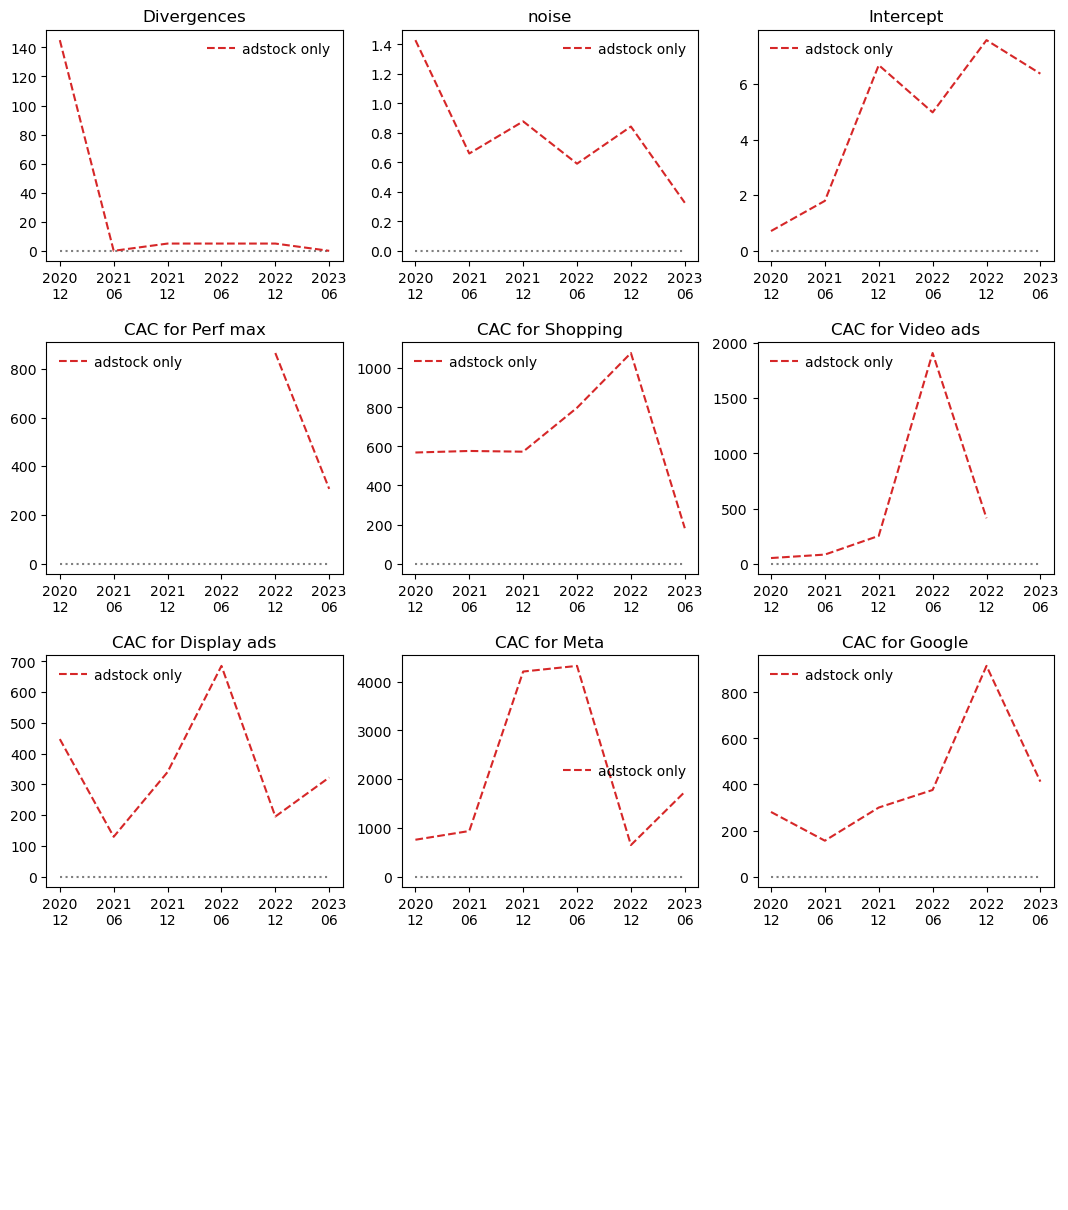

In [ ]:
# predictors - all channels other than 'Intercept'
predictors = [x for x in set(summaries.index.get_level_values(level=1)) if x != 'Intercept']

# pull together all the data we want to plot
to_plot = pd.concat([checks.loc[(['Divergences', 'noise'],slice(None)),:], \
                     summaries.loc['base',:].loc[('Intercept',slice(None)),:], \
                     summaries.loc['combined',:].loc[(predictors,slice(None)),:]], axis=0)
to_plot.columns = [col[:4]+'\n'+col[5:-3] for col in to_plot.columns]

# set the layout for our plots
charts_per_row = 3
params = ['Divergences', 'noise', 'Intercept'] + [''] * (charts_per_row-3) + \
         [x for x in predictors if x != 'Intercept']
params = params + [''] * (charts_per_row - len(predictors) % charts_per_row)
rows = int(len(params)/charts_per_row)

# line colors + styles
c = {'adstock - all': 'tab:blue', 'adstock - meta': 'tab:blue', 'adstock only': 'tab:red', 'no adstock': 'tab:red'}
ls = {'adstock - all': '-', 'adstock - meta': ':', 'adstock only': '--', 'no adstock': ':'} 

# generate the plots
fig, ax = plt.subplots(nrows=rows, ncols=charts_per_row, figsize=(13,rows*3.8))#, sharex=True)
for i in range(rows):
    for j in range(charts_per_row):
        x = ax[i, j]
        param = params[charts_per_row * i + j]
        if param == '':
            x.axis('off')
        else: 
            if param in predictors: x.set_title('CAC for ' + param)
            else: x.set_title(param)
            (to_plot.sum(axis=0) * 0).plot(ax=x, c='tab:gray', ls=':', label='_nolegend_')
            temp = to_plot.loc[([param],slice(None)),:].reset_index().copy()
            temp['legend'] = temp.model.apply(lambda x: x[x.find(',')+2:])
            temp.set_index('legend', inplace=True)
            temp = temp.drop(['param', 'model'], axis=1).T
            for col in temp.columns:
                temp[col].plot(ax=x, c=c[col], ls=ls[col])
            x.legend(frameon=False, columnspacing=1, handletextpad=0.5, handlelength=2)
plt.subplots_adjust(hspace=0.35)
plt.show()